# PIV on DE images

Velocimetry analysis is essential in the double emulsion experiment because:

1. it quantifies the bacterial activity (it's interesting to see if activity depends on droplet size)
2. it's an evaluation of the "steady-state" assumption: we can measure mean velocity at the beginning, in the middle and at the end of an experiment and compare the velocities.

Preliminary data shows that bacterial activity (mean velocity) increases with outer droplet size (OD20~40 data). Here, we do a thorough analysis on the whole data set. There are challenges on this analysis:

1. moving droplets: in some videos, the outer droplets move due to coalescence, evaporation and other reasons. Such motion affects PIV results significantly. Here we select the frames where outer droplet motion is negligible for the analysis.
2. change focus: in some videos, we change the focus to see inner droplets better. This leads to big error in PIV. We also review the video first and select appropriate frames for analysis. 
3. Masking: only the motions inside droplets are of interest. Here, we use the "fixed_mask_PIV" method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myimagelib.myImageLib import readdata
from myimagelib.pivLib import piv_data, read_piv, compact_PIV
from skimage import io
import os
from IPython.display import clear_output
import matplotlib
import cv2
from scipy.io import loadmat
from nd2reader import ND2Reader
from scipy.signal import savgol_filter

## 1 Set up images and parameters

In [6]:
folder = "/home/zhengyang/drives/Elements/"
date = "01182022"
n = 0
fps = 50
mpp = 0.16
nframe = 10
s = 0

# the following are inferred from above
img_folder = os.path.join(folder, date, "{:02d}".format(n), "raw")
mask_dir = os.path.join(folder, date, "mask", "{:02d}.tif".format(n))
lt = readdata(img_folder, "tif")
l = lt[s:s+nframe]
print("{0:d}/{1:d} frames loaded.".format(len(l), len(lt)))

# create droplet_image instance to call PIV method
di = droplet_image(l, fps, mpp)
di

10/16817 frames loaded.


length: 10, image size: (462, 480), fps: 50.0, mpp: 0.16

### 1.1 A preview tool with a slider
- To check if droplet or focus motion is significant

In [7]:
# load images and create frame number list
img_stack = {}
for num, i in l.iterrows():
    img_stack[int(i.Name)] = io.imread(i.Dir)
frame_numbers = l.Name.astype("int")

plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
def update(change):
    im.set_data(img_stack[change['new']])
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

### 1.2 Test PIV window size

In [8]:
# make a substack to make test process shorter
small_stack_length = 10
###
di_small = droplet_image(l.iloc[:small_stack_length], fps, mpp) # only take first two frames
di_small

length: 10, image size: (462, 480), fps: 50.0, mpp: 0.16

In [9]:
# compute PIV at various window sizes
piv_winsize = {}
for winsize in range(20, 80, 10):
    overlap = winsize // 2
    mask = io.imread(mask_dir)
    mask2 = cv2.erode(mask, np.ones([winsize, winsize]), iterations=1)
    piv, params = di_small.fixed_mask_piv(winsize, overlap, mask2)
    piv_winsize[winsize] = piv

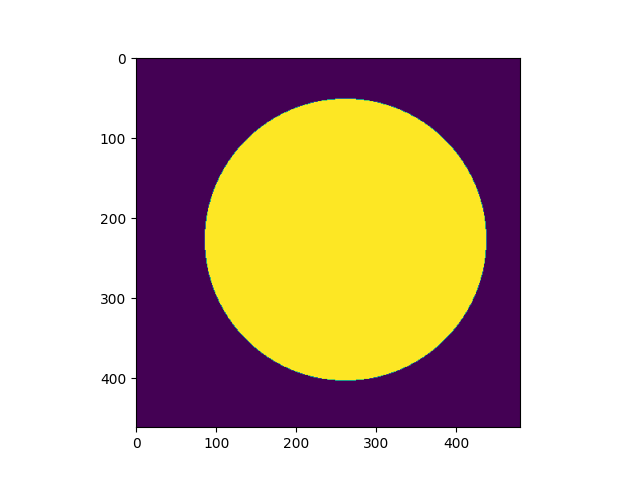

In [10]:
plt.figure()
plt.imshow(mask)

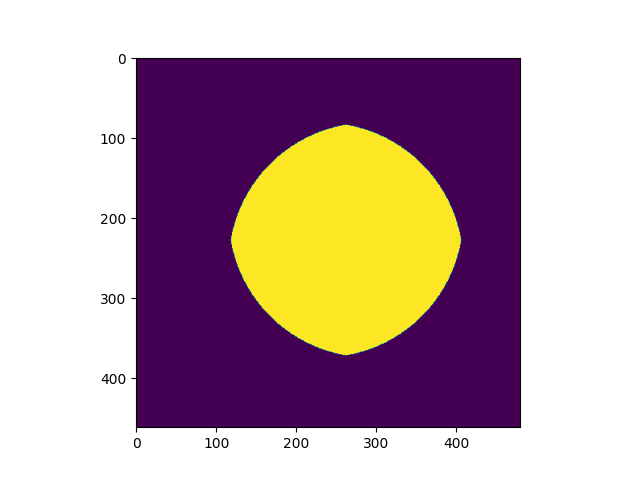

In [11]:
kernel = np.ones((60,60))
mask2 = cv2.erode(mask, kernel, iterations=1)
plt.figure()
plt.imshow(mask2)

#### 1.2.1 Mean velocity vs. window size

We first try different window sizes on the same image set and see if mean velocity depends strongly on the window size. 

In [12]:
def piv_mean_vel(piv):
    """Compute mean vel from dict PIV data."""
    s = 0
    count = 0
    for kw in piv:
        s += np.nanmean(piv[kw].u ** 2 + piv[kw].v ** 2) ** 0.5
        count += 1
    return s  / count

Text(0, 0.5, 'mean velocity (px/s)')

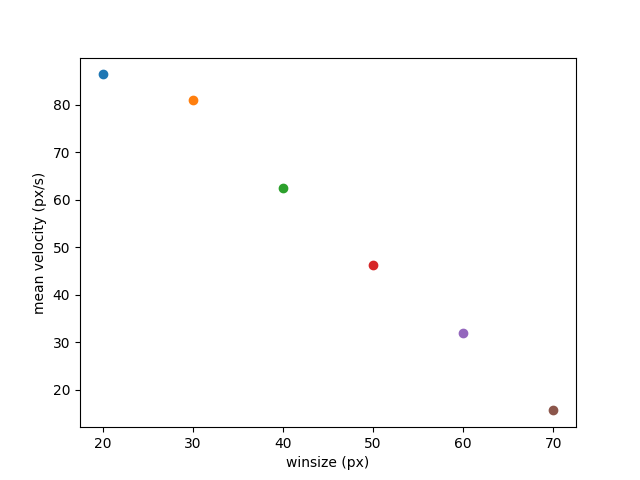

In [13]:
plt.figure()
for winsize in piv_winsize:
    piv = piv_winsize[winsize]
    plt.scatter(winsize, piv_mean_vel(piv))
plt.xlabel("winsize (px)")
plt.ylabel("mean velocity (px/s)")

#### 1.2.2 Visual inspection

Then we overlay the PIV results on images to double check the quality of PIV.

In [33]:
def piv_to_xyuv(pivData):
    """Convert piv dataframe to xyuv matrices."""
    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    X = np.array(pivData.x).reshape((row, col))
    Y = np.array(pivData.y).reshape((row, col))
    U = np.array(pivData.u).reshape((row, col))
    V = np.array(pivData.v).reshape((row, col))
    return X, Y, U, V

In [117]:
# visual inspection, check window size effect by slider animation
img = io.imread(di_small.sequence.iloc[0, 1])
winsize = list(piv_winsize.keys())[0]
piv = piv_winsize[winsize]
piv_item = piv[list(piv.keys())[0]]

plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()

plt.imshow(img, cmap="gray")
x, y, u, v = piv_to_xyuv(piv_item)
plt.quiver(x, y, u, v, color="yellow")

def update(change):
    plt.clf()
    plt.imshow(img, cmap="gray")
    winsize = change['new']
    piv = piv_winsize[winsize]
    piv_item = piv[list(piv.keys())[0]]
    x, y, u, v = piv_to_xyuv(piv_item)
    plt.quiver(x, y, u, v, color="yellow")
    fig.canvas.draw_idle()
    
drop = widgets.Dropdown(
            options=piv_winsize.keys(),
            value=list(piv_winsize.keys())[0],
            description='Window size',
            disabled=False)
drop.observe(update, names='value')
widgets.HBox([drop, fig.canvas])

In [118]:
# visual inspection: animation
# choose PIV data
winsize = 20
pivData = piv_winsize[winsize]
keys = list(pivData.keys())


plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
x, y, u, v = piv_to_xyuv(pivData[keys[0]])
uv = plt.quiver(x, y, u, v, color="yellow")
def update(change):
    frame = change['new']
    im.set_data(img_stack[frame])
    x, y, u, v = piv_to_xyuv(pivData["{0:05d}-{1:05d}".format(frame, frame+1)])
    uv.set_UVC(u, v)
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.HBox([slider, fig.canvas])

## 2 Run PIV at the determined window size

Sample 3 segments from the beginning, the middle and the end of the image sequence. 

In [250]:
winsize = 20
length = 50
start = 500

In [251]:
vm_list = []
for segment in [lt[start: start+length], lt[len(lt)//2:len(lt)//2+length], lt[-length:]]:
    di = droplet_image(segment, fps, mpp) # only take first two frames
    piv, params = di.fixed_mask_piv(winsize, winsize//2, mask_dir)
    vm_list.append(piv_mean_vel(piv)*mpp)
print(vm_list)

[2.8488429524873733, 2.338512001523504, 2.6961715540378615]


## 3 Known issue of PIV

### 3.1 Window size dependence

Too sensitive to the choice of window size. The data below show how mean velocity depends on window size choice for a certain droplet experiment. I have to emphasize that this is a good, large droplet sample. For samples with worse image quality or slower flow, the dependence can be more unpredictable. Therefore, I am seeking a more robust method to quantify the bacterial activity.

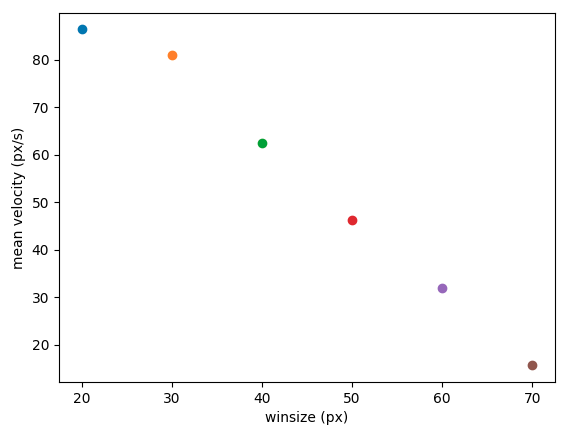

### 3.2 NaN velocities

The batch PIV code generates many velocity fields full of NaN, which is not expected. It might be related to the new version of PIV, which adds a strict sig2noise check. Here, we investigate this issue.

#### 3.2.1 Raw video and PIV data

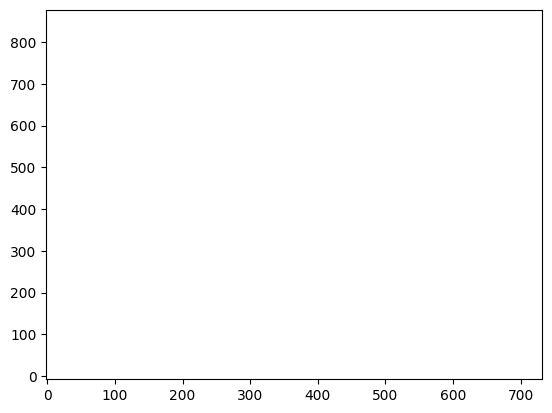

In [27]:
cpiv_dict = loadmat(r"D:\nd2\PIV\024.mat")
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(10000, by="index")
plt.quiver(x, y, u, v)

We find that video 024 has this issue. So let's do PIV on it step by step to see what is going wrong.

In [28]:
with ND2Reader(r"D:\nd2\024.nd2") as images:
    I0 = images[0]
    I1 = images[1]

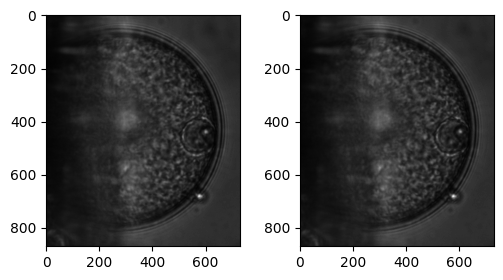

In [31]:
# display the images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(I0, cmap="gray")
ax[1].imshow(I1, cmap="gray")

The images look normal to me. Now let's start the PIV process.

#### 3.2.2 Try function `myimagelib.pivLib.PIV` 

In [66]:
from myimagelib.pivLib import PIV, apply_mask

In [48]:
x, y, u, v = PIV(I0, I1, 32, 16, 0.02)

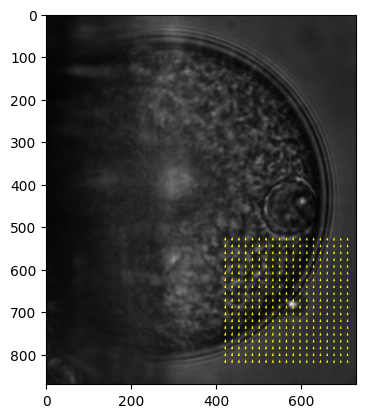

In [49]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

#### 3.2.3 Decompose PIV function into steps

The PIV function is an integrated process, including normal PIV, validation and outlier replacement. To identify the source of the NaN issue, let's decompose the `PIV` function and test step by step.

In [63]:
from openpiv import pyprocess, validation, filters

In [52]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        I0.astype(np.int32),
        I1.astype(np.int32),
        window_size=32,
        overlap=16,
        dt=0.02,
        search_area_size=32,
        sig2noise_method='peak2peak',
    )

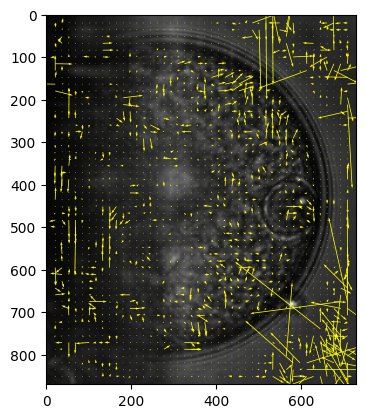

In [53]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u0, v0, color="yellow")

The intial `pyprocess.extended_search_area_piv` gives velocities everywhere. Then `PIV` includes a validation step, which uses the information of signal to noise ratio.

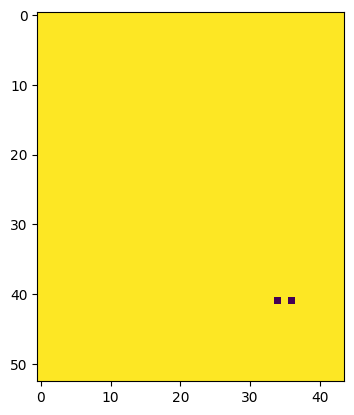

In [61]:
invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1.05,
    )
plt.imshow(invalid_mask)

We can see, with the critical s2n ratio 1.05, most of the velocities are marked as invalid. If we modify the threshold to 1, we get

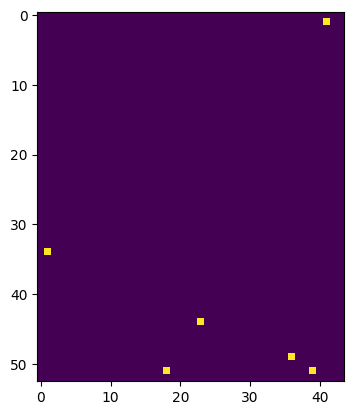

In [62]:
invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1,
    )
plt.imshow(invalid_mask)

A lot more velocities are valid now.

In [64]:
u2, v2 = filters.replace_outliers(
        u0, v0,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

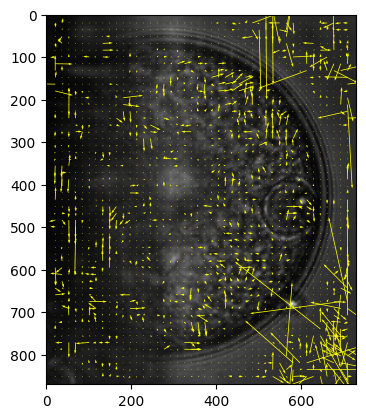

In [65]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u2, v2, color="yellow")

We can try applying the mask for in-droplet region.

In [68]:
mask = io.imread(r"D:\nd2\mask\024.tif")
pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u2.flatten(), "v": v2.flatten()})
pivData = apply_mask(pivData, mask)

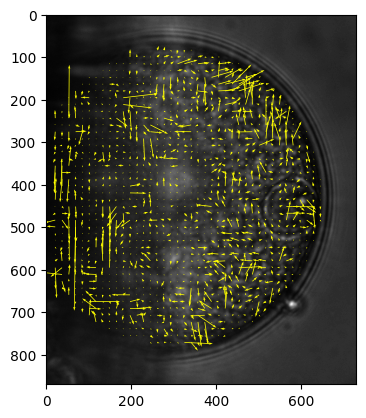

In [71]:
p = pivData.loc[pivData["mask"]==True]
plt.imshow(I0, cmap="gray")
plt.quiver(p.x, p.y, p.u, p.v, color="yellow")

#### 3.2.4 Concluding remarks

The result look OK to me. So in the end, the issue comes from the s2n ratio check, which tends to mark most of the PIV results as invalid. I admit that in some cases the image quality is not great for PIV analysis. But in most cases, the threshold 1.05 seems too strict, since I can observe motions with my naked eye in the images without ambiguity. 

After this investigation, I decide to change the default s2n ratio threshold to 1. This should resolve most of the NaN problems. 

### 3.3 Unfinished PIV analysis

I notice that some PIV .mat data are incomplete: the videos are 30,000 frames long, while the PIV data only consists ~1000 files. In this section, we look for these incomplete data and complete them. 

In [4]:
# automatically look for incomplete data.
# if len(images) // 2 > len(u), then data is incomplete
piv_folder = r"D:\nd2\PIV"
img_folder = r"D:\nd2"
l = readdata(piv_folder, "mat")
for num, i in l.iterrows():
    nd2Dir = os.path.join(img_folder, "{}.nd2".format(i.Name))
    with ND2Reader(nd2Dir) as images:
        nImages = len(images)
    cpiv_dict = loadmat(i.Dir)
    cpiv = compact_PIV(cpiv_dict)
    nPIV = len(cpiv.data["u"])
    if nImages // 2 > nPIV:
        print("{0} is incomplete ({1:d}/{2:d})".format(i.Name, nPIV, nImages//2))

038 is incomplete (15250/10243)
039 is incomplete (15250/1037)
050 is incomplete (15250/12038)
051 is incomplete (15250/409)
178 is incomplete (15000/8658)
186 is incomplete (15000/13721)
187 is incomplete (15000/3880)


After checking the log of the script, I realize that the incomplete PIV data is a result of nd2reader error, which might be related to corrupted nd2 files (nd2 files are so easily corrupted!). Therefore, even if I rerun the script, I might end up in at the same incomplete files, because the same nd2 file will be read again. A good practice is still saving the nd2 images to tif and then perform the PIV analysis, but that is going to be much heavier load for the computer. For now, let's just focus on the complete data. If incomplete data are necessary, we can treat them with special care.

#### 3.3.1 Identify a corrupted point

Note: the raw nd2 file here is too large, so I don't save it on GitHub. Therefore, this section of code cannot be execute unless you have the access to the nd2 file. Use video#51 as an example.

In [16]:
cpiv_dict = loadmat(r"D:\nd2\PIV\051.mat")
cpiv = compact_PIV(cpiv_dict)
labels = cpiv.get_labels()
labels[-1]

'00816-00817'

The label above should be the last frame pair that PIV succeeded. Meaning that frame 24076 or 24077 is not accessible. Let's try

In [25]:
nd2Dir = r"D:\nd2\051.nd2"
with ND2Reader(nd2Dir) as images:
    I0 = images[819]

But they are all fine, meaning that if I restart the PIV script, it's likely that the job can continue. Let's try. I will unpack 51.mat, then delete 51.mat.

In [26]:
cpiv.to_csv(r"D:\nd2\PIV\051")

#### 3.3.2 Batch unpack incomplete .mat files
It's true. The PIV job restarted from frame 817, and continues without problems. So the reason is not that the nd2 files are corrupted, but is something harder to reproduce and predict...

Here, I unpack all the incomplete data and rerun the scripts. Hope this time everything can be alright.

In [27]:
number_list = [38, 39, 50, 178, 186, 187]
for num in number_list:
    cpiv_dict = loadmat(r"D:\nd2\PIV\{:03d}.mat".format(num))
    cpiv = compact_PIV(cpiv_dict)
    cpiv.to_csv(r"D:\nd2\PIV\{:03d}".format(num))

## 4 Check PIV results

### 4.1 Check each one manually

In [4]:
n = 25
with ND2Reader(r"D:\nd2\{:03d}.nd2".format(n)) as images:
    I0 = images[0]
    I1 = images[1]
cpiv_dict = loadmat(r"D:\nd2\PIV\{:03d}.mat".format(n))
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)

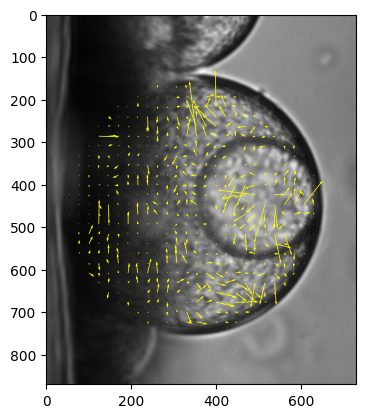

In [5]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

After changing the s2n ratio threshold, the results are back to normal, without the many NaN's.

### 4.2 Generate PIV overlay preview batch

In [4]:
piv_folder = r"D:\nd2\PIV"
img_folder = r"D:\nd2"
preview_folder = os.path.join(piv_folder, "overlay-preview")
if os.path.exists(preview_folder) == False:
    os.makedirs(preview_folder)
l = readdata(piv_folder, "mat")
for num, i in l.iterrows():
    previewDir = os.path.join(preview_folder, "{}.jpg".format(i.Name))
    if os.path.exists(previewDir) == False:
        print("generating preview for {}".format(i.Name))
        cpiv_dict = loadmat(i.Dir)
        cpiv = compact_PIV(cpiv_dict)
        x, y, u, v = cpiv.get_frame(0)
        nd2Dir = os.path.join(img_folder, "{}.nd2".format(i.Name))
        with ND2Reader(nd2Dir) as images:
            I0 = images[0]
        plt.imshow(I0, cmap="gray")
        plt.quiver(x, y, u, v, color="yellow")
        plt.savefig(previewDir)
        plt.close()
    else:
        print("{} exists, skip".format(i.Name))

023 exists, skip
024 exists, skip
025 exists, skip
030 exists, skip
035 exists, skip
037 exists, skip
038 exists, skip
039 exists, skip
048 exists, skip
050 exists, skip
051 exists, skip
052 exists, skip
162 exists, skip
166 exists, skip
168 exists, skip
172 exists, skip
173 exists, skip
174 exists, skip
175 exists, skip
178 exists, skip
181 exists, skip
182 exists, skip
183 exists, skip
184 exists, skip
186 exists, skip
187 exists, skip
189 exists, skip
190 exists, skip
191 exists, skip


### 4.3 Large velocities in dark region

From the preview overlay images, I notice that in some of the images, the bottom part of outer droplets are obscured by dark shadow, due to objects out of focus. These dark regions usually lead to abnormal PIV results, characterized by large magnitude of velocity. An example is shown below: (039)

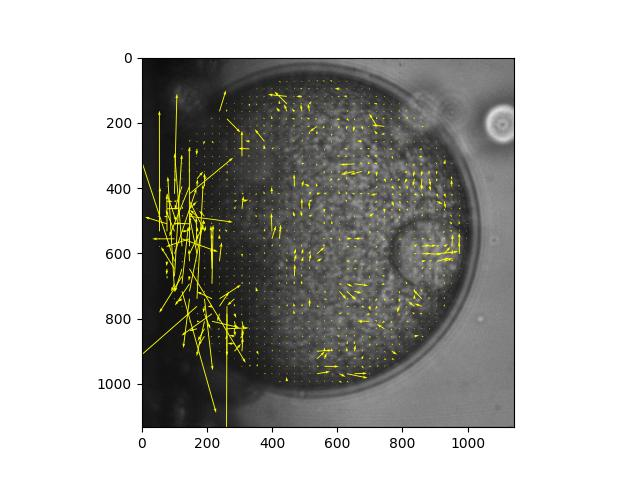

If we directly take average on velocity data like the above, we are going to have much larger velocity due to the errors in the dark region. An example of PIV that is not so much affected by dark shadow is shown below (166):

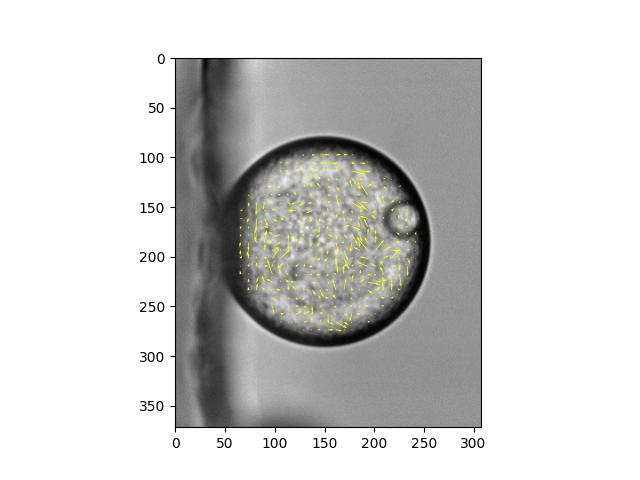

#### 4.3.1 Velocity magnitude threshold

To get rid of the errors, we first try to look at the histogram of velocity magnitude and decide a threshold to accept velocity data.

In [3]:
n = 39
with ND2Reader(r"D:\nd2\{:03d}.nd2".format(n)) as images:
    I0 = images[0]
cpiv_dict = loadmat(r"D:\nd2\PIV\{:03d}.mat".format(n))
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)

array([[<AxesSubplot: title={'center': 'mag'}>]], dtype=object)

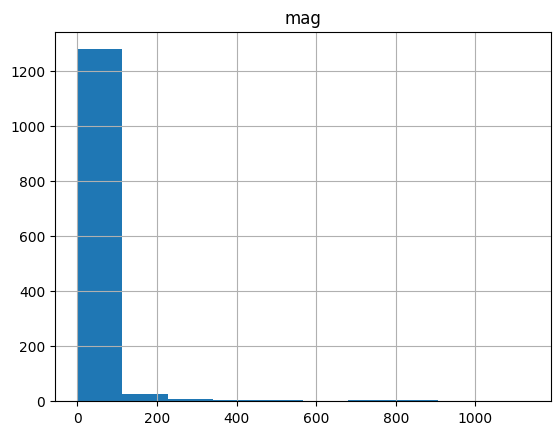

In [4]:
pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
pivData["mag"] = (pivData.u ** 2 + pivData.v ** 2) ** 0.5
pivData.hist("mag")

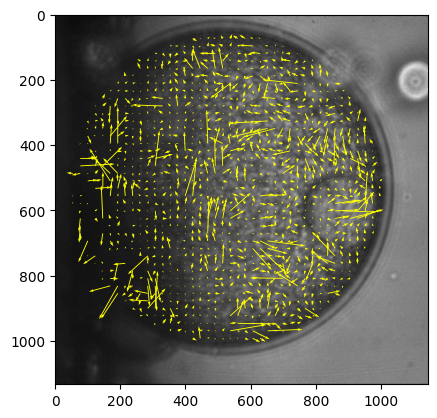

In [6]:
t = pivData.loc[pivData["mag"]<100]
plt.imshow(I0, cmap="gray")
plt.quiver(t.x, t.y, t.u, t.v, color="yellow")

An alternative way to visualize outliers is to scatter uv data in a plane, or plot 2D histogram. 

In [11]:
pivData = pivData.dropna()

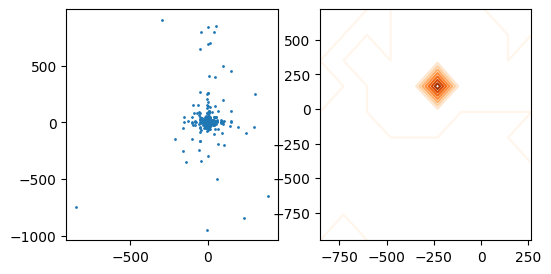

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
# scatter plot
ax[0].scatter(pivData.u, pivData.v, s=1)
# 2D histogram

H, xedges, yedges = np.histogram2d(pivData.u, pivData.v)
ax[1].contour(xedges[:-1], yedges[:-1], H, cmap="Oranges")

Somehow, the 2d histogram contour does not coincide with the most dense region in the scatter plot. Before I figure this out, I can just use the magnitude histogram to determine a threshold. 

#### 4.3.2 Mask out the dark regions
Alternatively, I can make a more conservative mask to mask out the bottom dark regions, as shown below.

![picture 1](../images/2023/01/new-mask.png)  


### 4.4 Check Chile PIV data

#### 4.4.1 Check only PIV data

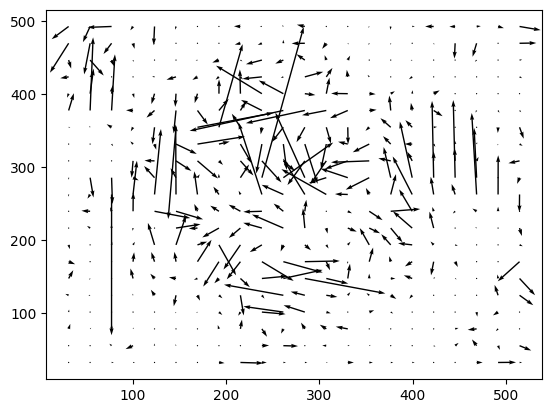

In [8]:
piv_folder = r"D:\Chile\PIV"
n = 110
cpiv_dict = loadmat(os.path.join(piv_folder, "{:03d}.mat".format(n)))
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)
plt.quiver(x, y, u, v)

#### 4.4.2 PIV on images

In [12]:
piv_folder = r"D:\Chile\PIV"
nd2_folder = r"D:\Chile\nd2"
n = 110
cpiv_dict = loadmat(os.path.join(piv_folder, "{:03d}.mat".format(n)))
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)
with ND2Reader(os.path.join(nd2_folder, "{:03d}.nd2".format(n))) as images:
    img = images[0]
plt.imshow(img, cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

EmptyFileError: No axes were found for this .nd2 file.

## 5 Results summary

The expected results are 
- .mat files with correct masks
- mean velocity vs. time data and plots
- for experiments with verified steady state, plot $\overline V$ vs. $D$ and $\overline V$ vs. OD.
- ...

### 5.1 Update the masks

1. Manually update masks according to the PIV overlay preview, save in "mask-revised" folder.
2. Apply masks in "mask-revised" folder to .mat PIV data, overwrite original .mat files.

In [3]:
piv_folder = r"D:\nd2\PIV"
mask_folder = r"D:\nd2\mask-revised"
l = readdata(piv_folder, "mat")
for num, i in l.iterrows():
    print("updating mask of {}".format(i.Name))
    cpiv_dict = loadmat(i.Dir)
    cpiv = compact_PIV(cpiv_dict)
    mask = io.imread(os.path.join(mask_folder, "{}.tif".format(i.Name)))
    cpiv.update_mask(mask)
    cpiv.to_mat(i.Dir)

updating mask of 023
updating mask of 024
updating mask of 025
updating mask of 030
updating mask of 035
updating mask of 037
updating mask of 038
updating mask of 039
updating mask of 048
updating mask of 050
updating mask of 051
updating mask of 052
updating mask of 162
updating mask of 166
updating mask of 168
updating mask of 172
updating mask of 173
updating mask of 174
updating mask of 175
updating mask of 178
updating mask of 181
updating mask of 182
updating mask of 183
updating mask of 184
updating mask of 186
updating mask of 187
updating mask of 189
updating mask of 190
updating mask of 191


### 5.2 Mean velocity vs. time

Here we use the root mean square of the whole velocity field at each instance as the mean velocity $\overline V(t)$:

$$
\overline V(t) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} |\mathbf{V}(t)|^2}
$$

- create .csv data in folder "mean-velocity"
- create plots and save in folder "mean-velocity-plot"

#### 5.2.1 Test

In [24]:
FPS = 50
MPP = 0.11

In [31]:
t = np.arange(len(meanv)) / FPS * 2
meanv = (cpiv.data["u"] ** 2 + cpiv.data["v"] ** 2).mean(axis=(1, 2)) ** 0.5 * MPP

(0.0, 599.96)

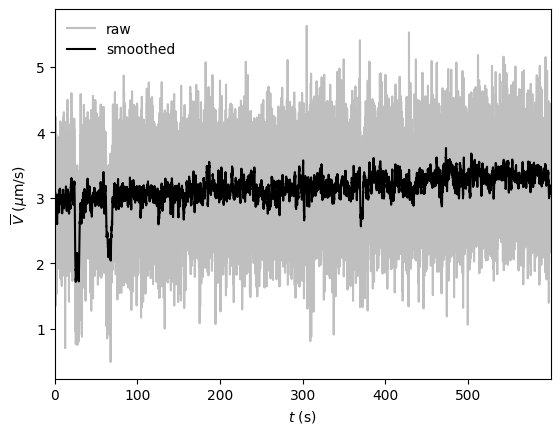

In [32]:
plt.plot(t, meanv, color="gray", alpha=.5, label="raw")
plt.plot(t, savgol_filter(meanv, 51, 3), color="black", label="smoothed")
plt.xlabel("$t$ (s)")
plt.ylabel("$\overline{V}$ ($\mu$m/s)")
plt.legend(frameon=False)
plt.xlim([0, t.max()])

#### 5.2.2 Batch generate data and plots

In [14]:
log = pd.read_csv(r"D:\nd2\log.csv")
piv_folder = r"D:\Chile\PIV"
meanv_folder = r"D:\Chile\PIV\mean-velocity"
if os.path.exists(meanv_folder) == False:
    os.makedirs(meanv_folder)
for num, i in log.set_index("DE#").iterrows():
    pivDir = os.path.join(piv_folder, "{:03d}.mat".format(num))
    if os.path.exists(pivDir):
        cpiv_dict = loadmat(pivDir)
        cpiv = compact_PIV(cpiv_dict)        
        meanv = (cpiv.data["u"] ** 2 + cpiv.data["v"] ** 2).mean(axis=(1, 2)) ** 0.5 * i.MPP
        t = np.arange(len(meanv)) / i.FPS * 2
        data = pd.DataFrame({"t": t, "v": meanv})
        data.to_csv(os.path.join(meanv_folder, "{:03d}.csv".format(num)))
        plt.plot(t[1000:], meanv[1000:], color="gray", alpha=.5, label="raw")
        plt.plot(t[1000:], savgol_filter(meanv[1000:], 51, 3), color="black", label="smoothed")
        plt.xlabel("$t$ (s)")
        plt.ylabel("$\overline{V}$ ($\mu$m/s)")
        plt.annotate(num, (0, 1), xycoords="axes fraction", fontsize=30, horizontalalignment="left", verticalalignment="top")
        plt.legend(frameon=False, loc="upper right")
        plt.xlim([0, t.max()])
        plt.savefig(os.path.join(meanv_folder, "{:03d}.jpg".format(num)))
        plt.close()

In [38]:
piv_folder = r"D:\nd2\PIV"
cpiv_dict = loadmat(os.path.join(piv_folder, "187.mat"))
cpiv = compact_PIV(cpiv_dict)
len(cpiv.get_labels())

3880